# RAFTS

In [1]:
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/riley/Desktop/RAFTS/Notebooks
/Users/riley/Desktop/RAFTS


## Initialize and Calibrate Composite Spectra

Flux contribution of a flare corresponding to 10000K BB + MD spectrum with FF = 0.05. Expected = 0.5, Result = 0.5


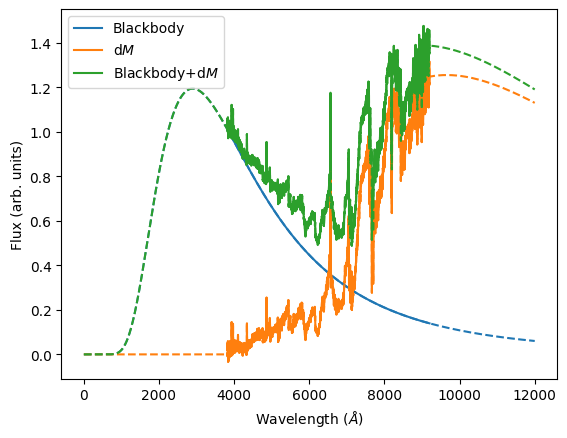

In [2]:
%matplotlib inline

import numpy as np 
import pandas as pd
import scipy
from utils import sed_integ, fitbb_to_m5, gen_mdspec, make_bb, lamb_eff_md, lamb_eff_BB, dcr_offset, dcr_offset_inverse, shiftedColorMap
from config import WAVELENGTH, WMAX, WMIN, AMS, MDSPEC
import globals
from importlib import reload
import matplotlib 
import matplotlib.pyplot as plt
from mdwarf_interp import mdwarf_interp

import warnings

def fxn():
    warnings.warn("runtime", RuntimeWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

globals.initialize()

TEMP = 10000

mdinterp = mdwarf_interp('m5.active.ha.na.k.fits', plotit=False)

md = mdinterp(WAVELENGTH)
amplitude = 1
res = scipy.optimize.minimize(fitbb_to_m5, [amplitude], args=(3000, md))
md[WAVELENGTH >= WMAX] = (make_bb(WAVELENGTH, 3000) * 1e27 * res.x)[WAVELENGTH >= WMAX]


bb = make_bb(WAVELENGTH, TEMP) * globals.BBnorm
md_bb = md + bb

def bb_fraction(md, T=10000, ff=globals.FF):
    bb = make_bb(WAVELENGTH, T) * globals.BBnorm
    ff = ff / globals.FF #makes ff = 1.0 by default
    md_bb = md + bb * ff
    return sed_integ(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX]*ff) / sed_integ(WAVELENGTH[WMIN:WMAX],md_bb[WMIN:WMAX])

#TEST:
result = bb_fraction(md)
print('Flux contribution of a flare corresponding to 10000K BB + MD spectrum with FF = 0.05. Expected = 0.5, Result = {}'.format(result))

assert result == 0.5, "WARNING: FAILED NORMALIZATION TEST"

plt.plot(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX], c='C0', label='Blackbody')
plt.plot(WAVELENGTH[WMIN:WMAX], md[WMIN:WMAX], c='C1', label=r'd$M$')
plt.plot(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX]+md[WMIN:WMAX], c='C2', label=r'Blackbody+d$M$')
plt.legend();
plt.plot(WAVELENGTH, bb, c='C0', ls='--', label='Blackbody')
plt.plot(WAVELENGTH, md, c='C1', ls='--', label='dM5')
plt.plot(WAVELENGTH, bb+md, c='C2', ls='--', label='BB+dM5')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux (arb. units)')
plt.savefig('Figures/bb_calib.png', dpi=300, bbox_inches='tight');

In [3]:
#what is the fract of total MD flux + BB ff 5% if BB T = 5000, what is total flux contributed by BB?

print(sed_integ(WAVELENGTH, md), sed_integ(WAVELENGTH[WMIN:WMAX], bb[WMIN:WMAX]),sed_integ(WAVELENGTH[WMIN:WMAX], md_bb[WMIN:WMAX]))

5762.863644472597 2354.9463148098052 4709.8926296196105


In [4]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

colors = ['#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#4B3713']

In [5]:
#Generate extended dM spectrum:
gen_mdspec(mdname=MDSPEC, filename='mdspec.npy', extended=True)

## New Composite Spectra using Davenport et al 2012

In [6]:
m5full = pd.read_table('/Users/riley/Desktop/RAFTS/m5_template.dat', comment='#', delim_whitespace=True, names=['wavelength', 'log_flux'], na_values=-99)

BB frac = 0.5000572769071517


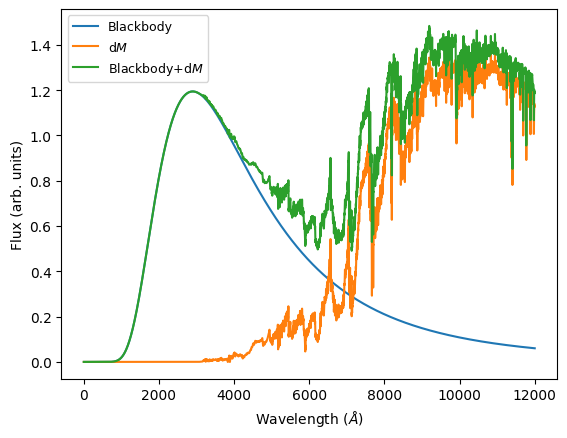

In [7]:
from scipy.interpolate.interpolate import interp1d
f = interp1d(m5full['wavelength'] * 10000, 10**m5full['log_flux'], bounds_error=False, fill_value=0.0)

md = f(WAVELENGTH)
md[np.isnan(md)] = 0.0

def fitbb_to_m5full(a, m5spec):
    result = np.abs(bb_fraction(m5spec * a) - 0.5)
    return result

amplitude = 1 / md.max()
res = scipy.optimize.minimize(fitbb_to_m5full, [amplitude], args=(md))
md *= res.x

bb = make_bb(WAVELENGTH, TEMP) * globals.BBnorm

md_bb = md + bb

#TEST:
result = bb_fraction(md)
print('BB frac = {}'.format(result))

np.save('mdspec_full.npy', md)

plt.plot(WAVELENGTH, bb, c='C0', label='Blackbody')
plt.plot(WAVELENGTH, md, c='C1', label=r'd$M$')
plt.plot(WAVELENGTH, bb+md, c='C2', label=r'Blackbody+d$M$')
plt.legend(fontsize = 9, loc = 'upper left');
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux (arb. units)')
plt.savefig('Figures/bb_calib.png', dpi=300, bbox_inches='tight');

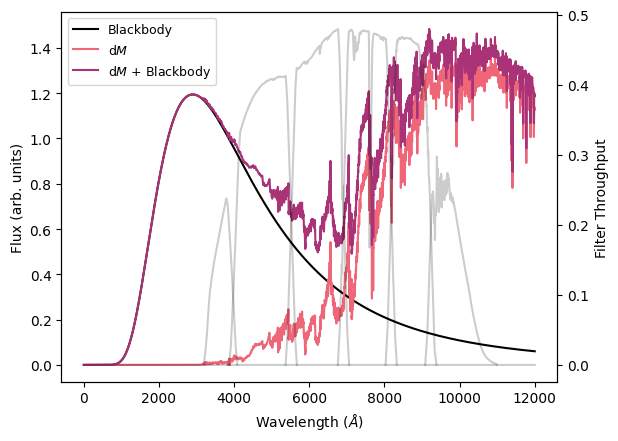

In [8]:
fig, ax = plt.subplots()

ax.plot(make_bb(WAVELENGTH, 10000) * globals.BBnorm, c='k', label='Blackbody')
ax.plot(np.load('mdspec_full.npy'), c=colors[3], label=r'd$M$')
ax.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm, c=colors[4],  label=r'd$M$ + Blackbody')

from utils import filt_interp

ax2 = ax.twinx()
ax2.set_ylabel('Filter Throughput')
ax2.tick_params(axis ='y')

for band in filters:
    f = filt_interp(band)
    ax2.plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k', alpha=0.2)

ax.plot(WAVELENGTH, np.full_like(WAVELENGTH, 0.0), c='k', alpha=0.2)

ax.legend(fontsize = 9, loc = 'upper left');
ax.set_xlabel(r'Wavelength ($\AA$)')
ax.set_ylabel('Flux (arb. units)')
fig.savefig('Figures/bb_calib.png', dpi=300, bbox_inches='tight');

[3655.8363666726095, 4740.959661180255, 6207.674731785824, 7596.890837423466, 8700.861308702217, 9728.225168498653]


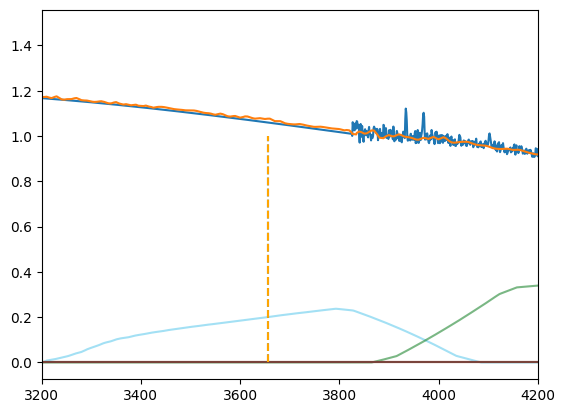

In [9]:
plt.plot(np.load('mdspec.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm)
plt.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm)

from utils import filt_interp

for band in filters:
    f = filt_interp(band)
    plt.plot(f(WAVELENGTH), c=filtercolors[band], alpha=0.6)


plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec.npy') for f in filters], 0.0, 1.0, ls='--', color='steelblue')
plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy') for f in filters], 0.0, 1.0, ls='--', color='orange')
print([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy') for f in filters])
plt.xlim(3200,4200);

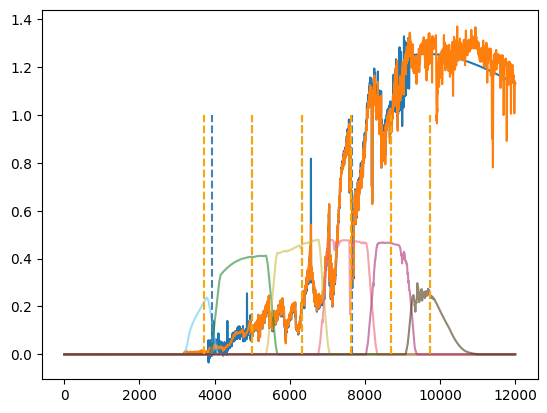

In [10]:
plt.plot(np.load('mdspec.npy'))
plt.plot(np.load('mdspec_full.npy'))

from utils import filt_interp

for band in filters:
    f = filt_interp(band)
    plt.plot(f(WAVELENGTH), c=filtercolors[band], alpha=0.6)

plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec.npy', mdonly=True) for f in filters], 0.0, 1.0, ls='--', color='steelblue')
plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy', mdonly=True) for f in filters], 0.0, 1.0, ls='--', color='orange')

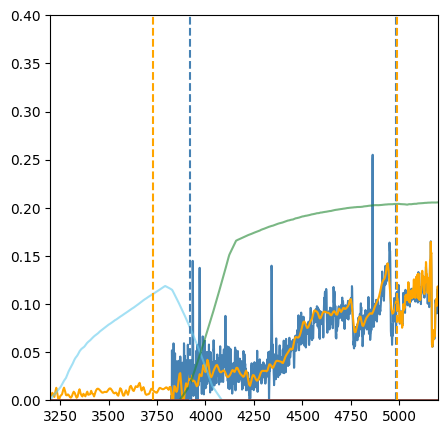

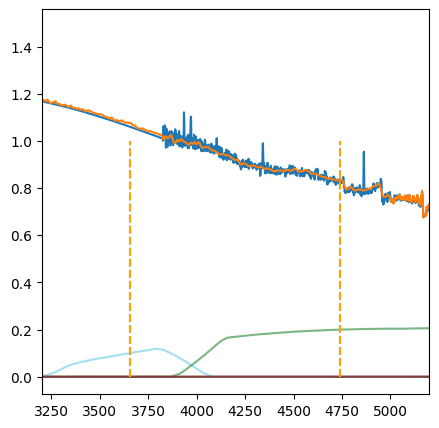

In [11]:
plt.figure(figsize=(5,5))

plt.plot(np.load('mdspec.npy'), color='steelblue')
plt.plot(np.load('mdspec_full.npy'), color='orange')

from utils import filt_interp

for band in filters:
    f = filt_interp(band)
    plt.plot(f(WAVELENGTH) * 0.5, c=filtercolors[band], alpha=0.6)

plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec.npy', mdonly=True) for f in filters], 0.0, 1.0, ls='--', color='steelblue')
plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy', mdonly=True) for f in filters], 0.0, 1.0, ls='--', color='orange')

plt.ylim(0,0.4)
plt.xlim(3200,5200);

plt.figure(figsize=(5,5))
plt.plot(np.load('mdspec.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm)
plt.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm)


for band in filters:
    f = filt_interp(band)
    plt.plot(f(WAVELENGTH) * 0.5, c=filtercolors[band], alpha=0.6)

plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec.npy', mdonly=False) for f in filters], 0.0, 1.0, ls='--', color='steelblue')
plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy', mdonly=False) for f in filters], 0.0, 1.0, ls='--', color='orange')

plt.xlim(3200,5200);

(6.262399192020299, 10.472317608484934, 128.86526441803073, 129.51863233414034)

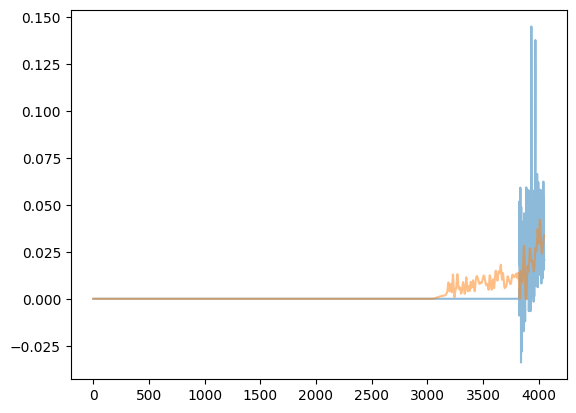

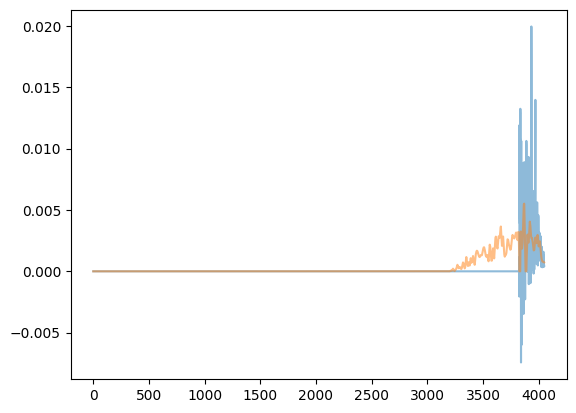

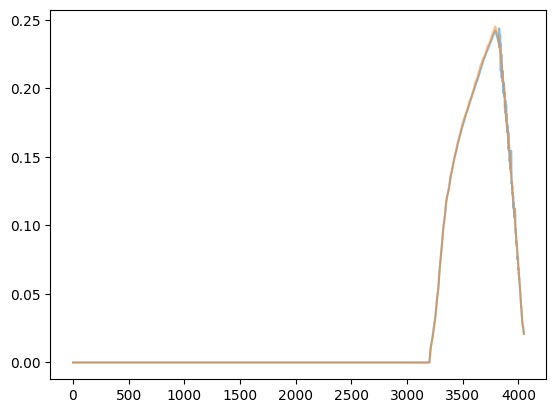

In [12]:
old = np.load('mdspec.npy') 
new = np.load('mdspec_full.npy') 

old_short = old[WAVELENGTH < 4050]
new_short = new[WAVELENGTH < 4050]

plt.plot(old_short, alpha=0.5)
plt.plot(new_short, alpha=0.5)

u = filt_interp("u")
g = filt_interp("g")
plt.figure()

plt.plot(old_short * u(WAVELENGTH[WAVELENGTH < 4050]), alpha=0.5)
plt.plot(new_short * u(WAVELENGTH[WAVELENGTH < 4050]), alpha=0.5)

plt.figure()

plt.plot((old_short  + make_bb(WAVELENGTH[WAVELENGTH < 4050], 10000) * globals.BBnorm) * u(WAVELENGTH[WAVELENGTH < 4050]), alpha=0.5)
plt.plot((new_short + make_bb(WAVELENGTH[WAVELENGTH < 4050], 10000) * globals.BBnorm) * u(WAVELENGTH[WAVELENGTH < 4050]), alpha=0.5)
old_short.sum(), new_short.sum(), np.nansum(((old_short  + make_bb(WAVELENGTH[WAVELENGTH < 4050], 10000) * globals.BBnorm)* u(WAVELENGTH[WAVELENGTH < 4050]))), \
   np.nansum (((new_short + make_bb(WAVELENGTH[WAVELENGTH < 4050], 10000) * globals.BBnorm)* u(WAVELENGTH[WAVELENGTH < 4050])))


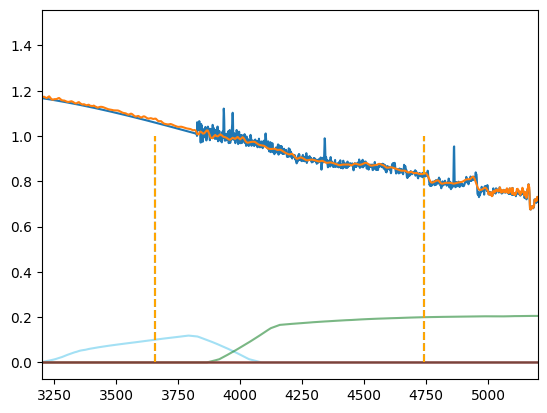

In [13]:
plt.plot(np.load('mdspec.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm)
plt.plot(np.load('mdspec_full.npy') + make_bb(WAVELENGTH, 10000) * globals.BBnorm)

from utils import filt_interp

for band in filters:
    f = filt_interp(band)
    plt.plot(f(WAVELENGTH) * 0.5, c=filtercolors[band], alpha=0.6)

plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec.npy', mdonly=False) for f in filters], 0.0, 1.0, ls='--', color='steelblue')
plt.vlines([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy', mdonly=False) for f in filters], 0.0, 1.0, ls='--', color='orange')

plt.xlim(3200,5200);

In [14]:
def mag(f):
    return 22.5 - 2.5 * np.log10(f)

Delta flux: 419.8133343295939
Delta mag: -2.3439564815980294


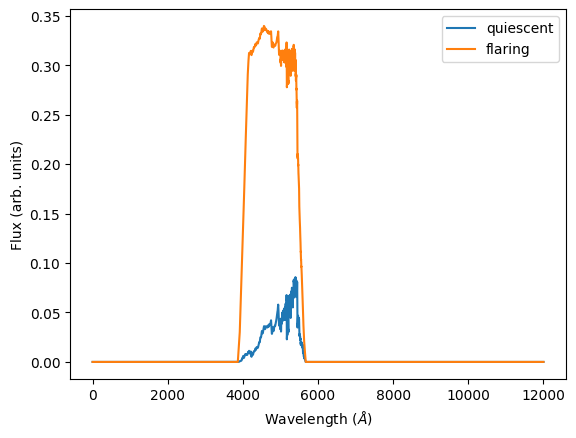

In [15]:
T = 10000

plt.plot(new * g(WAVELENGTH), label='quiescent')
plt.plot((new + make_bb(WAVELENGTH , T) * globals.BBnorm) * g(WAVELENGTH), label='flaring')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux (arb. units)')
plt.legend()

quiet_gflux = np.nansum(new * g(WAVELENGTH))
flaring_gflux = np.nansum((new + make_bb(WAVELENGTH, T) * globals.BBnorm) * g(WAVELENGTH))

print("Delta flux: {}".format(flaring_gflux - quiet_gflux))
print("Delta mag: {}".format(mag(flaring_gflux) - mag(quiet_gflux)))

## Visualizations

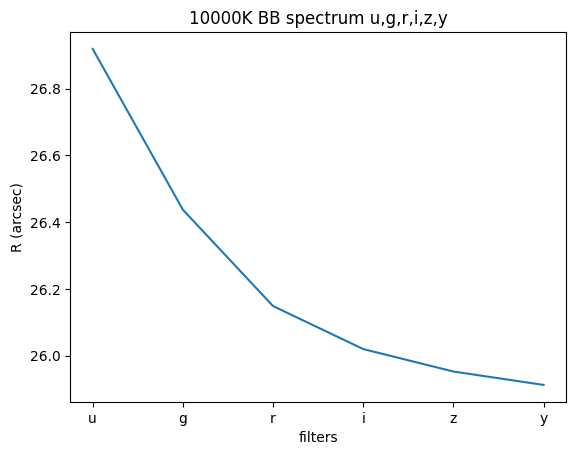

In [16]:
weff = np.array([lamb_eff_BB(band=f, temp=TEMP, verbose=False) for f in filters])
plt.plot(dcr_offset(weff, airmass = globals.airmass))
plt.xlabel("filters")
plt.ylabel("R (arcsec)")
plt.xticks(range(6), labels=["u","g","r","i","z","y"])
plt.title("{}K BB spectrum u,g,r,i,z,y".format(TEMP));

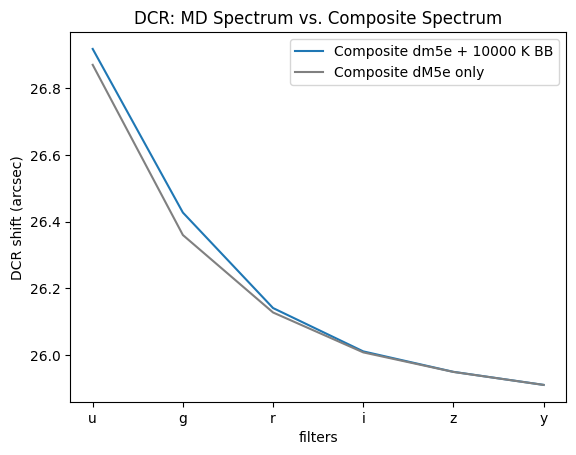

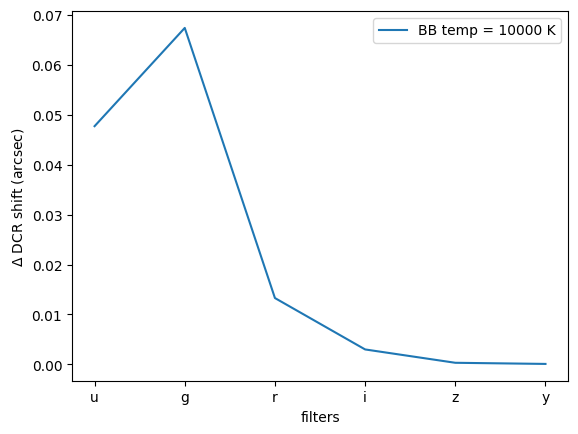

In [17]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

w_eff1 = np.array([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy', mdonly=True) for f in filters])
w_eff2 = np.array([lamb_eff_md(band=f, temp=TEMP, mdpath='mdspec_full.npy') for f in filters])

ax1.plot(dcr_offset(w_eff2, airmass = globals.airmass), label='Composite dm5e + {} K BB'.format(TEMP))
ax1.plot(dcr_offset(w_eff1, airmass = globals.airmass), c='grey', label="Composite dM5e only")

ax1.set_ylabel("DCR shift (arcsec)")
ax1.set_xlabel("filters")
ax1.set_xticks(range(6))
ax1.set_xticklabels(["u","g","r","i","z","y"])
ax1.set_title("DCR: MD Spectrum vs. Composite Spectrum")
ax1.legend()

ax2.plot(dcr_offset(w_eff2, airmass = globals.airmass) - dcr_offset(w_eff1, airmass = globals.airmass), label='BB temp = {} K'.format(TEMP))
ax2.set_ylabel(r"$\Delta$ DCR shift (arcsec)")
ax2.set_xlabel("filters")
ax2.set_xticks(range(6))
ax2.set_xticklabels(["u","g","r","i","z","y"])
ax2.legend()

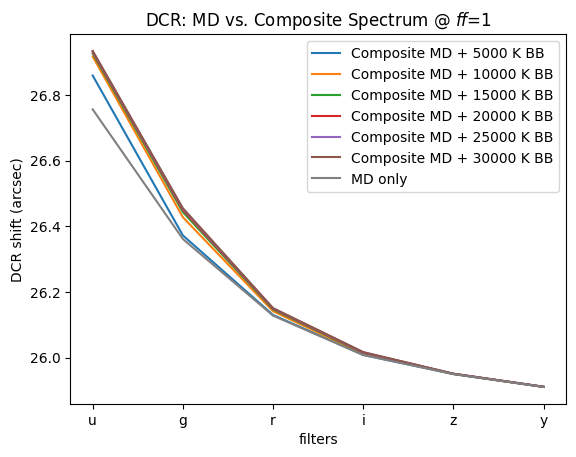

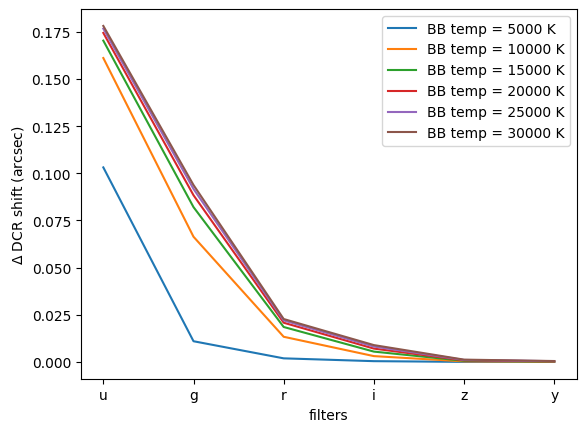

In [18]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

for temp in range(5000,35000,5000):

    w_eff1 = np.array([lamb_eff_md(band=f, temp=temp, mdonly=True) for f in filters])
    w_eff2 = np.array([lamb_eff_md(band=f, temp=temp) for f in filters])

    ax1.plot(dcr_offset(w_eff2, airmass = globals.airmass), label='Composite MD + {} K BB'.format(temp))
    ax2.plot(dcr_offset(w_eff2, airmass = globals.airmass) - dcr_offset(w_eff1, airmass = globals.airmass), label='BB temp = {} K'.format(temp))

ax1.plot(dcr_offset(w_eff1, airmass = globals.airmass), c='grey', label="MD only")
ax1.set_ylabel("DCR shift (arcsec)")
ax1.set_xlabel("filters")
ax1.set_xticks(range(6))
ax1.set_xticklabels(["u","g","r","i","z","y"])
ax1.set_title(r"DCR: MD vs. Composite Spectrum @ $ff$=1")
ax1.legend()


ax2.set_ylabel(r"$\Delta$ DCR shift (arcsec)")
ax2.set_xlabel("filters")
ax2.set_xticks(range(6))
ax2.set_xticklabels(["u","g","r","i","z","y"])
ax2.legend()

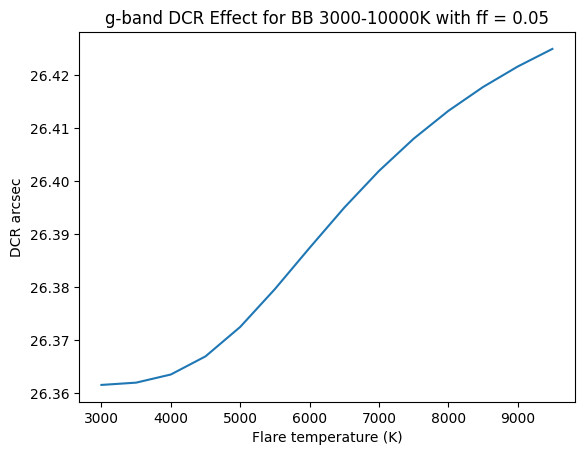

In [19]:
w_eff = np.array([lamb_eff_md(band='g', temp=t) for t in range(3000,10000,500)])
plt.plot(range(3000,10000,500), dcr_offset(w_eff, airmass = globals.airmass))
plt.ylabel("DCR arcsec")
plt.xlabel("Flare temperature (K)")
plt.title("g-band DCR Effect for BB 3000-10000K with ff = 0.05");

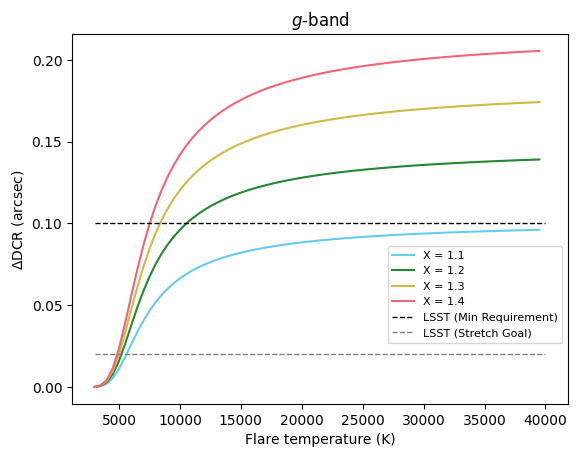

In [20]:
ams = [1.1,1.2,1.3,1.4]
temps = np.arange(3000,40000,500)

w_eff1 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF, mdonly=True) for t in temps])
w_eff2 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF) for t in temps])

for color, am in zip(colors,ams):
    plt.plot(temps, dcr_offset(w_eff2, airmass = am)-dcr_offset(w_eff1, airmass = am), c=color, label="X = {}".format(am))
    

plt.hlines(0.1,3000,40000, color='black', ls='--', lw=1, label='LSST (Min Requirement)')
plt.hlines(0.02,3000,40000, color='grey', ls='--', lw=1, label='LSST (Stretch Goal)')
plt.ylabel(r"$\Delta$DCR (arcsec)")
plt.xlabel("Flare temperature (K)")
plt.title(r"$g$-band")
plt.legend(fontsize=8, loc=4, bbox_to_anchor=(1,0.15))
plt.savefig('Figures/deltashifttemp_g.png', dpi=300, bbox_inches='tight')

In [21]:
#DC21engi dDCR
w_eff1 = np.array(lamb_eff_md(band='g', temp=5120, ff=globals.FF, mdonly=True))
w_eff2 = np.array(lamb_eff_md(band='g', temp=5120, ff=globals.FF))
dcr_offset(w_eff2, airmass = 1.2)-dcr_offset(w_eff1, airmass = 1.2)

0.018220498934937268

### Temp vs Airmass Heatmap

In [22]:
#generate grid
bins = 20
grid = np.zeros([bins,bins])

ams = np.arange(1.05, 2.05, 0.05)
temps = np.arange(2000, 42000, 2000)

x = np.load('Notebooks/baseline3.0_am.npy')
y = np.load('Notebooks/ef3temps.npy')

for i, am in enumerate(ams):
    for j, temp in enumerate(temps):
        w_eff1 = np.array(lamb_eff_md(band='g', temp=temp, ff=globals.FF, mdonly=True))
        w_eff2 = np.array(lamb_eff_md(band='g', temp=temp, ff=globals.FF))
        grid[i][j] = dcr_offset(w_eff2, airmass = am) - dcr_offset(w_eff1, airmass = am)

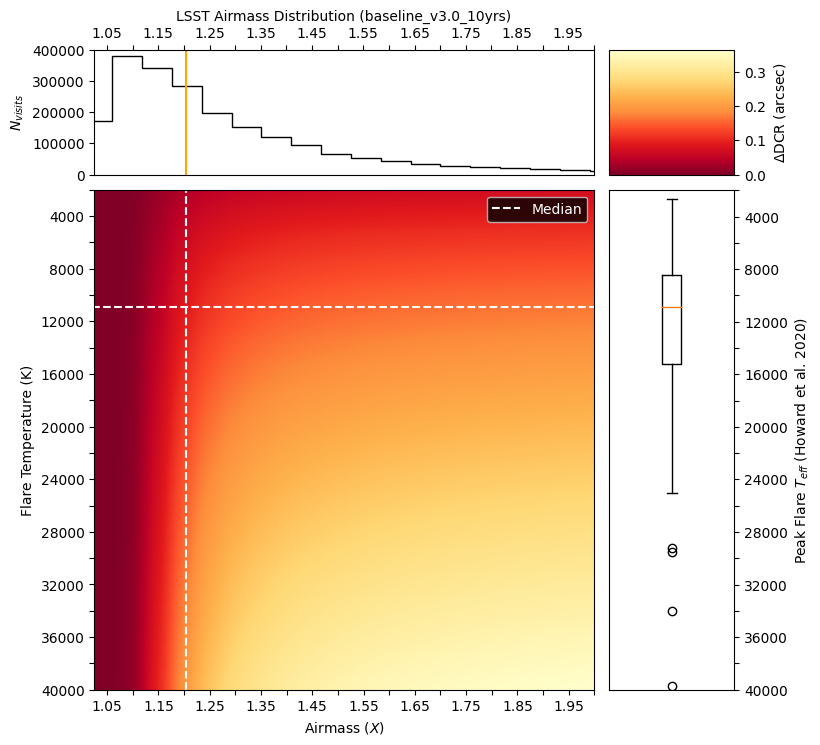

In [23]:
#Plotting
fig = plt.figure(figsize=(8,8))

fig.tight_layout()

gs = fig.add_gridspec(2, 2,  width_ratios=(4,1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax_img = fig.add_subplot(gs[1,0])
ax_boxh = fig.add_subplot(gs[0,0], sharex=ax_img)
ax_boxv = fig.add_subplot(gs[1,1], sharey=ax_img)
ax_cbar = fig.add_subplot(gs[0,1])

centers = [ams.min(),ams.max(),temps.max(),temps.min()]
dx, = np.diff(centers[:2])/(grid.shape[1]-1)
dy, = -np.diff(centers[2:])/(grid.shape[0]-1)
extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]
img = ax_img.imshow(grid, cmap='YlOrRd_r', interpolation='gaussian', extent=extent)
ax_img.hlines((np.median(y)-2000) / 2000, (1.05-1.05) / 0.05, (2.0-1.05) / 0.05, color='white', linestyles='--', label='Median')
ax_img.vlines((np.median(x)-1.05) / 0.05, (2000-2000) / 2000, (40000-2000) / 2000,  color='white', linestyles='--')
ax_img.hlines(np.median(y), 1.0, 2.0, color='white', linestyles='--')
ax_img.vlines(np.median(x), 0, 40000,  color='white', linestyles='--')

ax_img.set_xticks(np.arange(centers[0], centers[1]+dx, dx))
ax_img.set_yticks(np.arange(centers[3], centers[2]+dy, dy))

for label in ax_img.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

for label in ax_img.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax_img.set_position([0.1,0.1,0.625,0.625])
ax_img.set_aspect('auto')
ax_img.set_xlabel(r'Airmass ($X$)')
ax_img.set_ylabel('Flare Temperature (K)')
cbar = fig.colorbar(img, cax=ax_cbar)
cbar.set_label(r'$\Delta$DCR (arcsec)')
ax_img.legend(facecolor='k', labelcolor='white')

from scipy.stats import kurtosis
N = len(x)
N_bins = 1 + np.log2(N) + np.log2(1 + kurtosis(x) * np.sqrt(N / 6))

ax_boxh.hist(x, bins=int(N_bins), color='k', histtype='step')
ax_boxh.vlines(np.median(x), 0, 400000, color='orange')
ax_boxh.set_xlim(1.0 + dx / 2, 2.0)
ax_boxh.set_ylim(0,400000)
ax_boxh.xaxis.tick_top()
ax_boxh.set_ylabel(r'$N_{visits}$')
ax_boxh.set_xlabel('LSST Airmass Distribution (baseline_v3.0_10yrs)')
ax_boxh.xaxis.set_label_position('top')

for label in ax_boxh.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

ax_boxv.boxplot(y, vert=True)
ax_boxv.set_ylim(2000,40000)
ax_boxv.set_xticks([])
ax_boxv.yaxis.tick_right()
ax_boxv.invert_yaxis()
ax_boxv.set_ylabel(r'Peak Flare $T_{eff}$ (Howard et al. 2020)')
ax_boxv.yaxis.set_label_position('right')

for label in ax_boxv.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.savefig('Figures/temp_am_grid.png', dpi=300, bbox_inches='tight')


For an observed flare, given flare temp, given temp distribution (Howard et al.)

-observe a flare, assume some astrometric precision q

-A_crit(T) = critical airmass at T where deltaDCR > q

-$P(\Delta DCR) = P(airmass > A_{crit}(T) | T)$

P10k = 0.568
P10k = 0.525
P10k = 0.271
P10k = 0.041


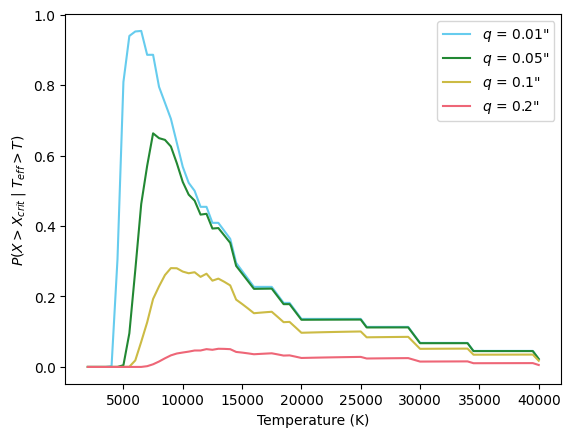

In [24]:
ams = np.arange(1.05, 3.05, 0.05)
temps = np.arange(2000, 40500, 500)
qs = [0.01,0.05,0.1,0.2]

for i, q in enumerate(qs):
    pdcr = []
    for temp in temps:
        ptemp = len(y[y >= temp]) / len(y)
        am_crit = dcr_offset_inverse(w_eff_1 = lamb_eff_md(band='g', temp=temp, ff=globals.FF),
                                     w_eff_0 = lamb_eff_md(band='g', temp=temp, ff=globals.FF, mdonly=True), dcr=q)
        
        pam = len(x[x > am_crit]) / len(x)
        ptotal = ptemp * pam
        pdcr.append(ptotal)
        if temp == 10000:
            print('P10k = {0:.3f}'.format(ptotal))
    plt.plot(temps, pdcr, color=colors[i], label=r'$q$ = {}"'.format(q))

plt.ylabel(r'$P(X > X_{crit}\;|\;T_{eff} > T)$')
plt.xlabel(r'Temperature (K)')
plt.legend()
plt.savefig('Figures/dcr_prob.png', dpi=300, bbox_inches='tight')

Other baselines:

In [25]:
baselines = pd.read_csv('/Users/riley/Desktop/RAFTS/baselines_airmasses.csv', usecols=[1,2,3,4,5])
baselines.head()

,baseline_v3.0,baseline_v2.2,baseline_v2.1,baseline_v2.0,retro_baseline_v2.0
0,1.033698,1.039333,1.172534,1.172534,1.103477
1,1.047116,1.053375,1.207046,1.207046,1.088316
2,1.034846,1.067421,1.248190,1.248190,1.115869
3,1.445493,1.088284,1.295605,1.295605,1.131347
4,1.501800,1.111693,1.371481,1.371481,1.149825


P10k = 0.525
P10k = 0.511
P10k = 0.513
P10k = 0.516
P10k = 0.470


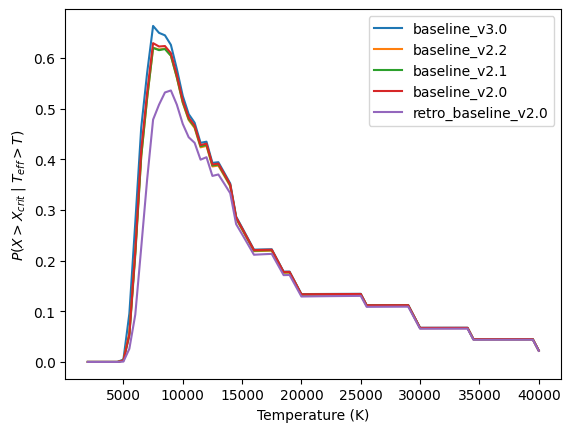

In [27]:
ams = np.arange(1.05, 3.05, 0.05)
temps = np.arange(2000, 40500, 500)
q = 0.05

for i, col in enumerate(baselines.columns):
    pdcr = []
    for temp in temps:
        ptemp = len(y[y >= temp]) / len(y)
        am_crit = dcr_offset_inverse(w_eff_1 = lamb_eff_md(band='g', temp=temp, ff=globals.FF),
                                     w_eff_0 = lamb_eff_md(band='g', temp=temp, ff=globals.FF, mdonly=True), dcr=q)
        
        pam = len(baselines[col].values[baselines[col].values > am_crit]) / len(baselines[col].values)
        ptotal = ptemp * pam
        pdcr.append(ptotal)
        if temp == 10000:
            print('P10k = {0:.3f}'.format(ptotal))

    #if col == 'baseline_v3.0':
        #plt.fill_between(temps, pdcr, np.zeros_like(pdcr), alpha=0.5)
    plt.plot(temps, pdcr, label='{}'.format(col))

plt.ylabel(r'$P(X > X_{crit}\;|\;T_{eff} > T)$')
plt.xlabel(r'Temperature (K)')
#plt.title('q = {}'.format(q))
plt.legend()
plt.savefig('Figures/dcr_prob_2.0.png', dpi=300, bbox_inches='tight')

### Total DCR Plots

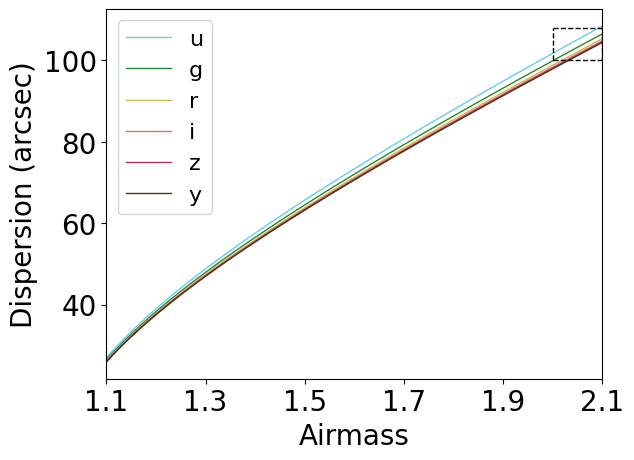

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

ams = np.arange(1.1,2.11,0.01)

for b in filters:
    w_eff = np.array(lamb_eff_BB(band=b, temp=10000))
    plt.plot(ams, dcr_offset(w_eff, airmass = ams), color=filtercolors[b], lw=1, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 6))
plt.tick_params(labelsize=20)
ax.vlines([2.0, 2.1], 100, 108, color='k', lw=1, ls='--')
ax.hlines([100, 108], 2.0, 2.1, color='k', lw=1, ls='--')
plt.xlabel('Airmass', fontsize=20)
plt.ylabel('Dispersion (arcsec)', fontsize=20)
plt.legend(fontsize=16, loc='upper left')
plt.savefig('Figures/better_dcrfig_0.png', dpi=300, bbox_inches='tight')

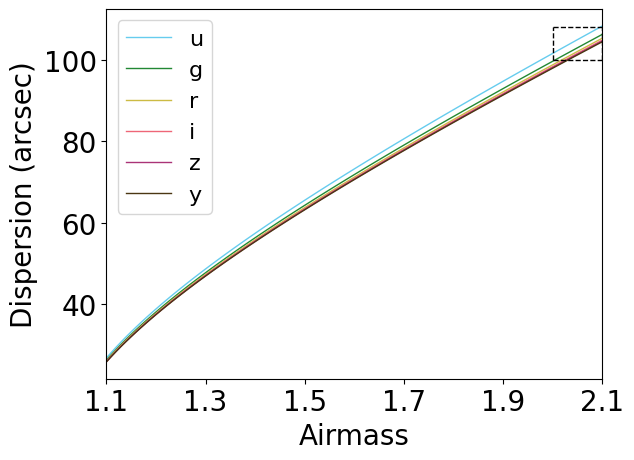

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

ams = np.arange(1.1,2.11,0.01)

for b in filters:
    w_eff = np.array(lamb_eff_md(band=b, temp=0, mdonly=True))
    plt.plot(ams, dcr_offset(w_eff, airmass = ams), color=filtercolors[b], lw=1, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 6))
plt.tick_params(labelsize=20)
ax.vlines([2.0, 2.1], 100, 108, color='k', lw=1, ls='--')
ax.hlines([100, 108], 2.0, 2.1, color='k', lw=1, ls='--')
plt.xlabel('Airmass', fontsize=20)
plt.ylabel('Dispersion (arcsec)', fontsize=20)
plt.legend(fontsize=16, loc='upper left')

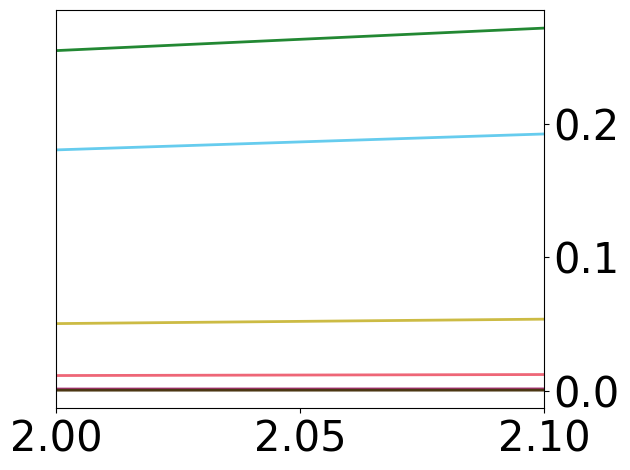

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111)

ams = np.arange(2.0,2.1,0.01)

for b in filters:

    plt.plot(ams, dcr_offset(np.array(lamb_eff_md(band=b, temp=10000)), airmass = ams) - 
                  dcr_offset(np.array(lamb_eff_md(band=b, temp=10000, mdonly=True)), airmass = ams), color=filtercolors[b], lw=2, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 3))

ax.yaxis.tick_right()
plt.tick_params(labelsize=30)
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.tight_layout()

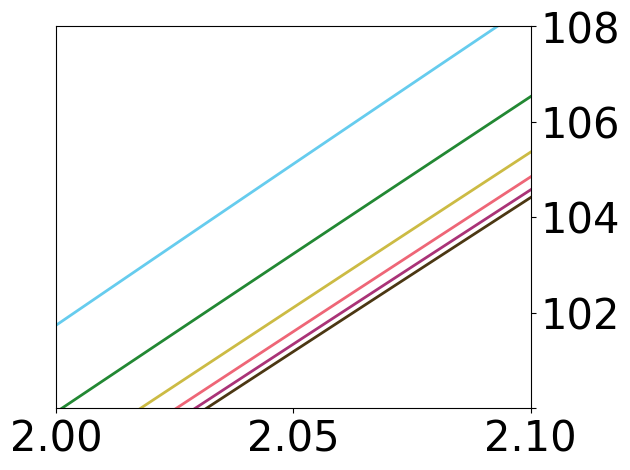

In [119]:
fig = plt.figure()
ax = fig.add_subplot(111)

ams = np.arange(2.0,2.1,0.01)

for b in filters:
    w_eff = np.array(lamb_eff_BB(band=b, temp=10000))
    plt.plot(ams, dcr_offset(w_eff, airmass = ams), color=filtercolors[b], lw=2, label='{}'.format(b))

plt.xlim(ams.min(), ams.max())
plt.xticks(np.linspace(ams.min(), ams.max(), 3))
plt.ylim(100,108)
ax.yaxis.tick_right()
plt.tick_params(labelsize=30)
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.tight_layout()
plt.savefig('Figures/better_dcrfig_1.png', dpi=300)


### Astrometric Error plots

In [120]:
def dcr_curve(temps, band, airmass):

    w_eff1 = np.array([lamb_eff_md(band=band, temp=t, ff=globals.FF, mdonly=True) for t in temps])
    w_eff2 = np.array([lamb_eff_md(band=band, temp=t, ff=globals.FF) for t in temps])

    ddcr = dcr_offset(w_eff2, airmass = airmass) - dcr_offset(w_eff1, airmass = airmass)

    return ddcr

In [121]:
def errorplot(testtemps, band, airmass):

    temps = range(3000,60000,500)
    testtemps = [5000, 10000, 25000]
    curve = dcr_curve(temps, band, airmass)

    plt.plot(temps, curve)

    for testtemp in testtemps:
        curvetest = dcr_curve([testtemp], band, airmass)
        lower = curvetest - 0.05
        upper = curvetest + 0.05
        xerr_lower = temps[np.where(curve == curve[min(range(len(curve)), key = lambda i: abs(curve[i] - lower))])[0][0]]
        xerr_upper = temps[np.where(curve == curve[min(range(len(curve)), key = lambda i: abs(curve[i] - upper))])[0][0]]
        print('Flare temp = {0}K: Upper error bound = {1}K, lower error bound = {2}K'.format(testtemp, xerr_upper, xerr_lower))
        plt.errorbar(testtemp, curvetest, yerr = 0.05, xerr = [[testtemp - xerr_lower], [xerr_upper - testtemp]], marker='o', capsize=3)

    plt.ylabel(r"$\Delta$ DCR shift (arcsec)")
    plt.xlabel("Flare temperature (K)")
    plt.title('{0}-band, airmass={1}'.format(band, airmass));

Flare temp = 5000K: Upper error bound = 7500K, lower error bound = 3000K
Flare temp = 10000K: Upper error bound = 59500K, lower error bound = 6000K
Flare temp = 25000K: Upper error bound = 59500K, lower error bound = 8000K


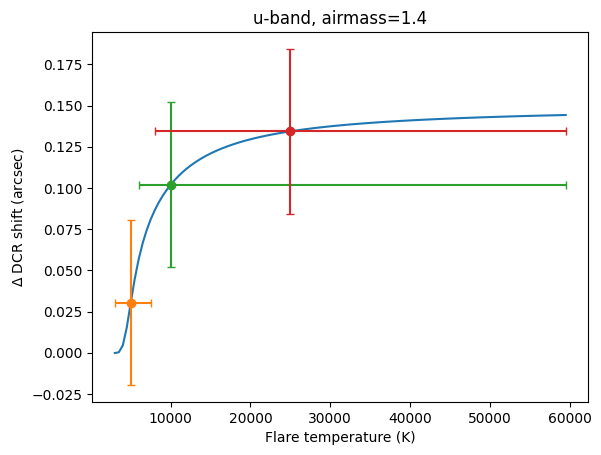

In [122]:
errorplot(testtemps=[5000, 10000, 25000], band='u', airmass=1.4)

Flare temp = 5000K: Upper error bound = 6500K, lower error bound = 3000K
Flare temp = 10000K: Upper error bound = 21500K, lower error bound = 7000K
Flare temp = 25000K: Upper error bound = 59500K, lower error bound = 10500K


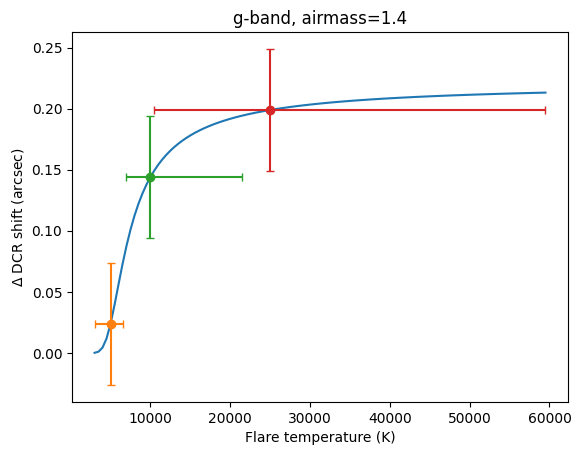

In [123]:
errorplot(testtemps=[5000, 10000, 25000], band='g', airmass=1.4)

Flare temp = 5000K: Upper error bound = 5500K, lower error bound = 4000K
Flare temp = 10000K: Upper error bound = 12000K, lower error bound = 9000K
Flare temp = 25000K: Upper error bound = 59500K, lower error bound = 16000K


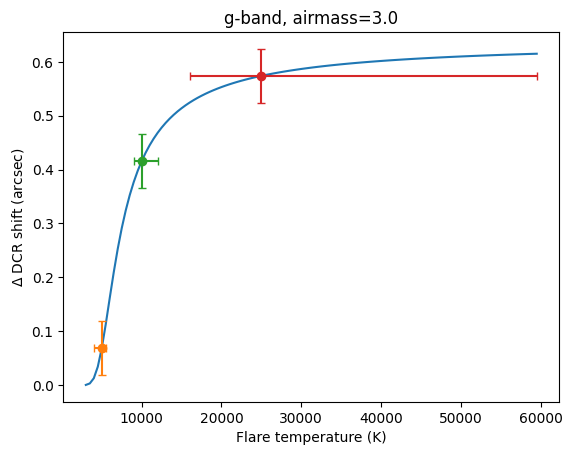

In [124]:
errorplot(testtemps=[5000, 10000, 25000], band='g', airmass=3.0)

### Filter-airmass Gridplots

In [125]:
def makegrid(temp, ff, ams, delta=False):

    grid = np.zeros((6,6))

    ams = ams

    if delta:
        for i, am in enumerate(ams):
            for j, f in enumerate(filters):
                w_eff1 = lamb_eff_md(band=f, temp=temp, ff=ff, mdonly=True) 
                w_eff2 = lamb_eff_md(band=f, temp=temp, ff=ff) 
                grid[i][j] = dcr_offset(w_eff2, airmass=am) - dcr_offset(w_eff1,airmass=am)

    else:
        for i, am in enumerate(ams):
            for j, f in enumerate(filters):
                w_eff = lamb_eff_md(band=f, temp=temp, ff=ff) 
                grid[i][j] = dcr_offset(w_eff, airmass=am)

    return grid

In [126]:
#Generate grids
temp, ff = 5000, globals.FF*4
grid = makegrid(temp, ff, AMS)
deltagrid = makegrid(temp, ff, AMS, delta=True)

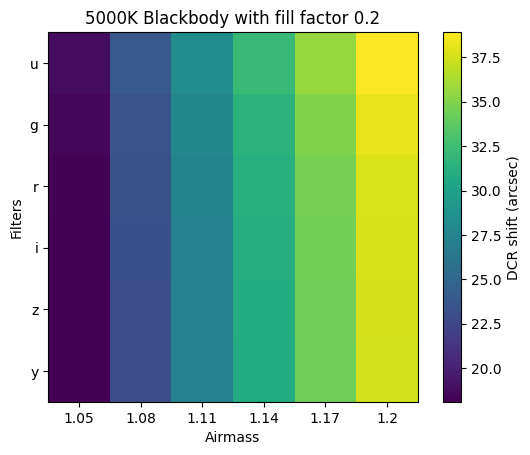

In [127]:
fig3, ax3 = plt.subplots(1,1)

c = ax3.imshow(grid.T)

ax3.set_xticks(range(6))
ax3.set_xticklabels(np.round(AMS, decimals=2))
ax3.set_yticks(range(6))
ax3.set_yticklabels(["u","g","r","i","z","y"])
ax3.set_ylabel("Filters")
ax3.set_xlabel("Airmass")
ax3.set_title('{0}K Blackbody with fill factor {1}'.format(temp, ff))

cbar = fig3.colorbar(c)
cbar.set_label('DCR shift (arcsec)', rotation=90)


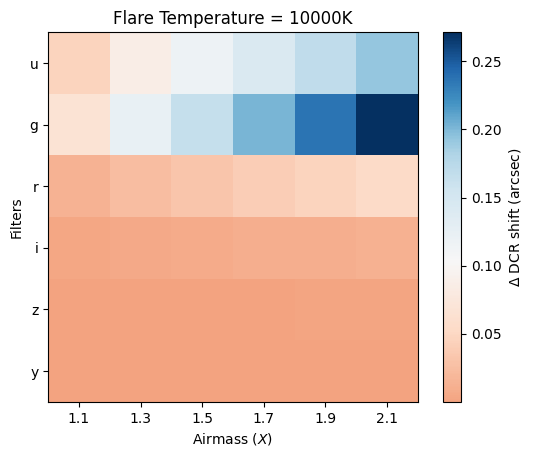

In [137]:
#Generate grids
temp, ff = 10000, globals.FF
AMS = np.linspace(1.1,2.1,6)
deltagrid = makegrid(temp, ff, AMS, delta=True)

q = 0.1
start = 0.3
mp = (q / (deltagrid.max() - deltagrid.min())) + start

orig_cmap = matplotlib.cm.RdBu
shifted_cmap = shiftedColorMap(orig_cmap, start=start, midpoint=mp, name='shifted')

fig3, ax3 = plt.subplots(1,1)

#c = ax3.imshow(deltagrid.T, cmap='Blues', norm=colors.LogNorm(vmin=0.01, vmax=0.4))
c = ax3.imshow(deltagrid.T, cmap=shifted_cmap)

ax3.set_xticks(range(6))
ax3.set_xticklabels(np.round(AMS, decimals=2))
ax3.set_yticks(range(6))
ax3.set_yticklabels(["u","g","r","i","z","y"])
ax3.set_ylabel("Filters")
ax3.set_xlabel(r"Airmass ($X$)")
ax3.set_title('Flare Temperature = {0}K'.format(temp))

cbar = fig3.colorbar(c)
cbar.set_label(r'$\Delta$ DCR shift (arcsec)', rotation=90)

plt.savefig('Figures/deltagridlog{}.png'.format(temp), dpi=300, bbox_inches='tight')

In [21]:
temp0, ff0 = 5000, globals.FF
deltagrid0 = makegrid(temp0, ff0, AMS, delta=True)

temp1, ff1 = 10000, globals.FF
deltagrid1 = makegrid(temp1, ff1, AMS, delta=True)

temp2, ff2 = 20000, globals.FF
deltagrid2 = makegrid(temp2, ff2, AMS, delta=True)

temp3, ff3 = 40000, globals.FF
deltagrid3 = makegrid(temp3, ff3, AMS, delta=True)

temp4, ff4 = 5000, globals.FF*4
deltagrid4 = makegrid(temp4, ff4, AMS, delta=True)

temp5, ff5 = 10000, globals.FF*4
deltagrid5 = makegrid(temp5, ff5, AMS, delta=True)

temp6, ff6 = 20000, globals.FF*4
deltagrid6 = makegrid(temp6, ff6, AMS, delta=True)

temp7, ff7 = 40000, globals.FF*4
deltagrid7 = makegrid(temp7, ff7, AMS, delta=True)

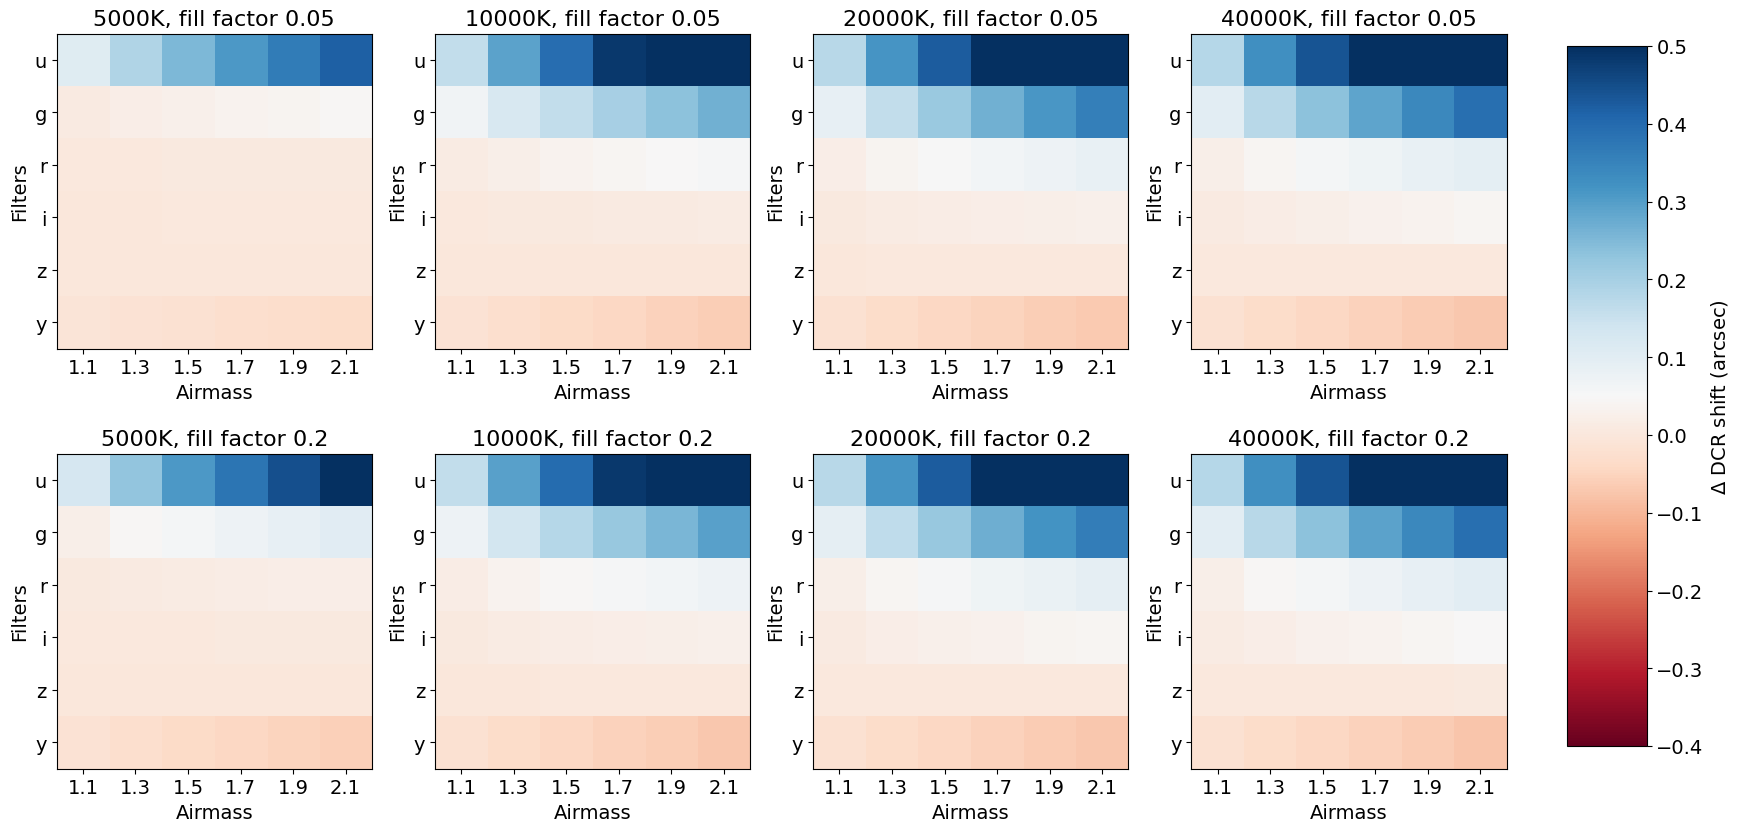

In [26]:
gridtemps = [5000,10000,20000,40000]
gridffs = [globals.FF, globals.FF*4]

#deltagrids = np.array([makegrid(gf,gt,AMS,delta=True) for gf, gt in gridffs, gridtemps])

fig5, ax5 = plt.subplots(2,4, figsize=(20,10))

for i, gf in enumerate(gridffs):
    for j, gt in enumerate(gridtemps):

        deltagrid = makegrid(gt, gf, AMS, delta=True)
        c = ax5[i,j].imshow(deltagrid.T, cmap='RdBu', clim=(-0.4, 0.5))
        ax5[i,j].set_xticks(range(6))
        ax5[i,j].set_xticklabels(np.round(AMS, decimals=2), fontsize=14)
        ax5[i,j].set_yticks(range(6))
        ax5[i,j].set_yticklabels(["u","g","r","i","z","y"], fontsize=14)
        ax5[i,j].set_ylabel("Filters", fontsize=14)
        ax5[i,j].set_xlabel("Airmass", fontsize=14)
        ax5[i,j].set_title('{0}K, fill factor {1}'.format(gt,gf), fontsize=16)

fig5.subplots_adjust(right=0.85)
cbar_ax = fig5.add_axes([0.88, 0.15, 0.04, 0.7])
cbar = fig5.colorbar(c, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\Delta$ DCR shift (arcsec)', fontsize=14)
plt.savefig("Figures/8grid.png", dpi=500, bbox_inches='tight')

## Making a cartoon DCR gif

In [28]:
#Simmed dDCR shift plot
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

np.random.seed(11037) #LEON!

#Invoke DCR machinery
temps = np.arange(3000,20000,500)
w_eff1 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF, mdonly=True) for t in temps])
w_eff2 = np.array([lamb_eff_md(band='g', temp=t, ff=globals.FF) for t in temps])
dcrs = dcr_offset(w_eff2, airmass = 1.4)-dcr_offset(w_eff1, airmass = 1.4)

#Init positions
ra_pos = np.random.normal(0.0,0.1,size=50)
dec_pos = np.random.normal(0.0,0.1,size=50)

#Plotting
for temp, dcr in zip(temps, dcrs):

    #Update positions
    ra_pos += np.random.normal(0.0,0.01,size=len(ra_pos))
    dec_pos += np.random.normal(0.0,0.01,size=len(dec_pos))

    #Update flr star position
    flr_ra_pos = 0.1 + dcr * (1/np.sqrt(2)) + np.random.normal(0.0,0.01,size=1)[0]
    flr_dec_pos = 0.1 + dcr * (1/np.sqrt(2)) + np.random.normal(0.0,0.01,size=1)[0]
 
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(ra_pos, dec_pos, alpha=0.75)
    ax.scatter(flr_ra_pos, flr_dec_pos, color='red', s=100, marker='*', label='Flare star')

    ax.plot([0,2],[0,2], c='gray',ls='--', label="to zenith")

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')


    ax.set_xlabel(r"$\Delta$ RA (arcsec)", labelpad=150)
    ax.set_ylabel(r"$\Delta$ Dec (arcsec)", labelpad=150)
    ax.set_xticks([-0.4,-0.2,0.2,0.4])
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(-0.5,0.5)
    ax.set_title("Flare temp: {0}K, Airmass = {1}".format(temp, 1.4))
    ax.legend()
    ax.grid(False)

    fig.gca().set_aspect('equal')
    fig.savefig('Figures/sim_gif_figs/{}Ksim.png'.format(temp),dpi=300,bbox_inches='tight')
    plt.close()

## Effects on PSF 

Let's examine how the PSF is affected by both DCR and chromatic seeing as we move across the passband

In [129]:
def makeGaussian(size, fwhm_x = 3, fwhm_y = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float) 
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 / fwhm_x**2 + (y-y0)**2 / fwhm_y**2) )

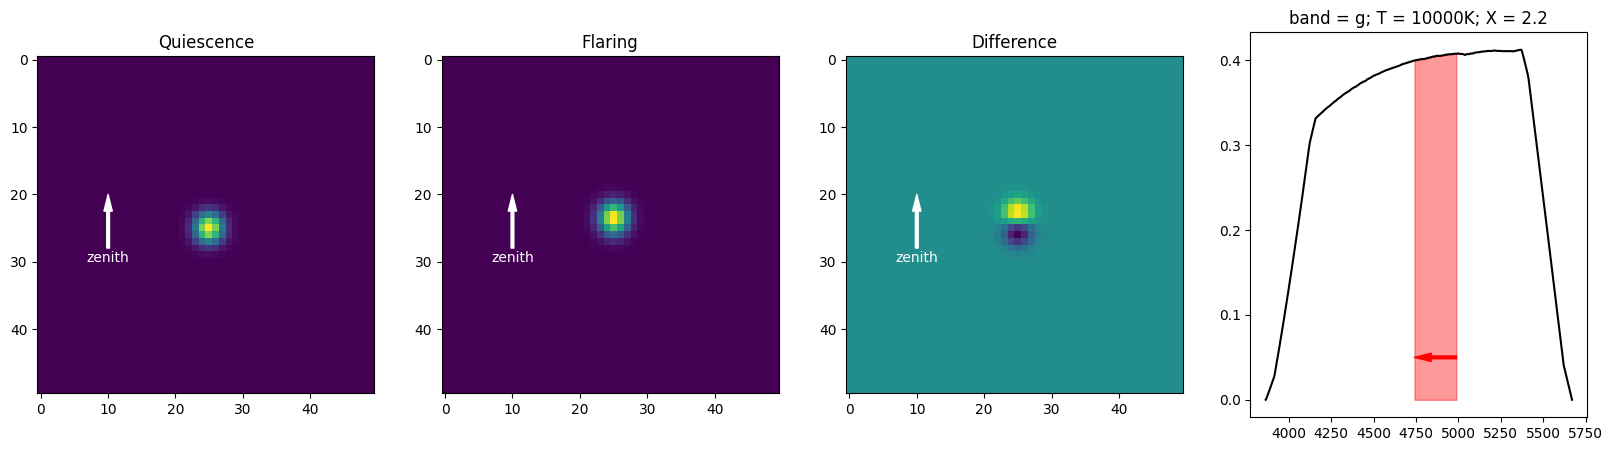

In [356]:
### Make quiescent and flaring PSFs for an input temp, airmass, etc


#set constants
size = 50
pixscale = 0.2 #arcsec/pixel
fwhm = 0.7 / pixscale #0.7" seeing
temp = 10000
am = 2.2
band= 'g'
f = filt_interp(band)


#import spectra
iSED = np.load('mdspec_full.npy')
fSED = np.load('mdspec_full.npy') + make_bb(WAVELENGTH, temp) * globals.BBnorm


#DCR First moment
def Rbar(SED):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    weff = np.exp(np.sum(p * np.log(WAVELENGTH[f(WAVELENGTH) > 0])) / np.sum(p))
    R = dcr_offset(weff, airmass = am) 
    
    return np.sum(p * R) / np.sum(p), weff

Rbar_i, weff_i = Rbar(iSED)
Rbar_f, weff_f = Rbar(fSED)
dRbar = Rbar_f - Rbar_i

#DCR Second moment
def V(SED):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    R = dcr_offset(WAVELENGTH[f(WAVELENGTH) > 0], airmass=am)
    Rbar = np.sum(p * R) / np.sum(p)

    return np.sum(p * (R-Rbar)**2) / np.sum(p)

V_i = V(iSED)
V_f = V(fSED)


#Make Gaussians
psf_i = makeGaussian(size, fwhm_x = fwhm, fwhm_y = fwhm + V_i)
psf_f = makeGaussian(size, fwhm_x = fwhm * (weff_f/weff_i)**(-2/5), fwhm_y = fwhm * (weff_f/weff_i)**(-2/5) + V_f, center=((size/2),(size/2 - (dRbar / pixscale))))

#Plotting
fig, ax = plt.subplots(1,4, figsize=(20,5))
a = ax[0].imshow(psf_i)
b = ax[1].imshow(psf_f)
c = ax[2].imshow(psf_f - psf_i)

ax[3].plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k')
ax[3].fill_between(x = WAVELENGTH[f(WAVELENGTH) > 0.0], y1 = f(WAVELENGTH)[f(WAVELENGTH) > 0.0], 
                   where = (WAVELENGTH[f(WAVELENGTH) > 0.0] < weff_i) & (WAVELENGTH[f(WAVELENGTH) > 0.0] > weff_f), color='red', alpha=0.4)

ax[0].set_title('Quiescence')
ax[1].set_title('Flaring')
ax[2].set_title('Difference')
ax[3].set_title('band = {}; T = {}K; X = {}'.format(band, temp, am))

for i in range(len(ax)):
    ax[i].annotate('zenith', xy = (size * 1/5, size * 2/5), xytext=(size * 1/5, size * 3/5), horizontalalignment='center', color='white',
    arrowprops = dict(facecolor='white', color='white', width=2, headwidth=6))

ax[3].annotate('', xytext = (weff_i,0.05), xy=(weff_f,0.05), horizontalalignment='center', color='white',
arrowprops = dict(facecolor='white', color='red', width=2, headwidth=6));

In [357]:
print('R = {0:.3f}"'.format(dRbar))
print('delta V = {0:.3f} pixels'.format(V_f - V_i))

print('FWHM multiplier: ',(weff_f/weff_i)**(-2/5))

R = 0.288"
delta V = 0.119 pixels
FWHM multiplier:  1.0205608059444709


change in effective wavelength only dialates the FWHM by ~3%

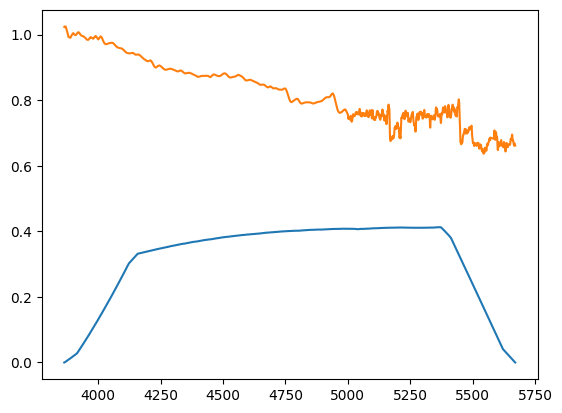

In [353]:
plt.plot(WAVELENGTH[f(WAVELENGTH) > 0], f(WAVELENGTH)[f(WAVELENGTH) > 0])
plt.plot(WAVELENGTH[f(WAVELENGTH) > 0], fSED[f(WAVELENGTH) > 0])

In [347]:
p = fSED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]

p[WAVELENGTH[f(WAVELENGTH) > 0] == 5000]

array([0.30858883])

In [ ]:
for ang in WAVELENGTH[f(WAVELENGTH) > 0]:

#set constants
size = 50
pixscale = 0.2 #arcsec/pixel
fwhm = 0.7 / pixscale #typical LSST seeing
temp = 10000
am = 1.2
band= 'g'
f = filt_interp(band)


#import spectra
SED = np.load('mdspec_full.npy') + make_bb(WAVELENGTH, temp) * globals.BBnorm
p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]

#Calculate effective wavelengths, DCR first- and second-moment shifts
l_f = lamb_eff_md(band = band, temp=temp)
l_i = lamb_eff_md(band = band, temp=temp, mdonly=True)

#DCR First moment
def Rbar(SED):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    weff = np.exp(np.sum(p * np.log(WAVELENGTH[f(WAVELENGTH) > 0])) / np.sum(p))
    R = dcr_offset(weff, airmass = am) 
    
    return np.sum(p * R) / np.sum(p)

Rbar_i = Rbar(iSED)
Rbar_f = Rbar(fSED)
dRbar = Rbar_f - Rbar_i

#DCR Second moment
def V(SED):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    R = dcr_offset(WAVELENGTH[f(WAVELENGTH) > 0], airmass=am)
    Rbar = np.sum(p * R) / np.sum(p)

    return np.sum(p * (R-Rbar)**2) / np.sum(p)

V_i = V(iSED)
V_f = V(fSED)


#Make Gaussians
psf = makeGaussian(size, fwhm_x = fwhm * (l_f/l_i)**(-2/5), fwhm_y = fwhm * (l_f/l_i)**(-2/5) + V_f, center=((size/2),(size/2 - (dRbar / pixscale))))

#Plotting
fig, ax = plt.subplots(1,2, figsize=(10,5))
a = ax[0].imshow(psf)

ax[3].plot(WAVELENGTH[f(WAVELENGTH) > 0.0], f(WAVELENGTH)[f(WAVELENGTH) > 0.0], c='k')
ax[3].fill_between(x = WAVELENGTH[f(WAVELENGTH) > 0.0], y1 = f(WAVELENGTH)[f(WAVELENGTH) > 0.0], 
                   where = (WAVELENGTH[f(WAVELENGTH) > 0.0] < l_i) & (WAVELENGTH[f(WAVELENGTH) > 0.0] > l_f), color='red', alpha=0.4)

ax[0].set_title('PSF')
ax[1].set_title('Bandpass')


for i in range(len(ax)):
    ax[i].annotate('zenith', xy = (size * 1/5, size * 2/5), xytext=(size * 1/5, size * 3/5), horizontalalignment='center', color='white',
    arrowprops = dict(facecolor='white', color='white', width=2, headwidth=6))

ax[3].annotate('', xytext = (l_i,0.05), xy=(l_f,0.05), horizontalalignment='center', color='white',
arrowprops = dict(facecolor='white', color='red', width=2, headwidth=6));